In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import modules.deep_model as DeepModel
import modules.model as Model 
import tensorflow as tf
import warnings
import numpy as np
import fasttext
import os

warnings.filterwarnings('ignore')

# Sử dụng CNN1D của Keras
* Phần này chúng ta sẽ thử sử dụng lại **word vectors** của Facebook cung cấp mà chúng ta đã dùng để trực quan hóa dữ liệu lên không gian 3 chiều, mục đích ta muốn biết liệu các **word vectors** này có hoạt động hiệu quả trên dataset của chúng ta không.
* Ở CNN, chúng ta sử dụng phép **convolution** [tích chập] giữa **window** [cửa số lọc] có kích thước 3x3, 5x5 - duyệt qua từng vùng tương ứng trên ảnh để tìm hiểu các đặc trưng phức tạp của hình ảnh.
* Vậy giả sử từng comment bao gồm $n$ từ, ta có thể dùng **fasttext 100 dimmensions cho một từ** mà ta đã làm ở project 2, như vậy lúc này một comment của chúng ta được chuyển đổi thành một ma trận có kích thước $100 \times n$.
* Nhưng lúc này các comment của chúng ta sẽ không thống nhất về chiều dài, nên ta sẽ ép chúng về chung một chiều dài $m$ nào đó và. Và với những comment có $n < m$, ta sẽ thay thế phần bù còn lại là một vector 0.
* Khi áp dụng CNN cho bài toán NLP, người ta hay áp dụng window có kích thước từ 2 đến 5. Giả sử window có kích thước là 5 thì chúng ta đang trượt qua comment và tính toán cho 5 từ một lúc, nó hoạt động như cách chúng ta code cho N-Grams ở project 2 vậy.
* Về mặt thời gian, thì CNN hoạt động nhanh hơn so với LSTM, tuy nhiên về mặt hiệu năng, khả năng cao kết quả cho ra không chính xác, vì mặc dù ta đại diện cho một từ là một vector 100 dimensions nhưng chưa có điều gì đủ để chứng minh các vector này phù hợp với tập dữ liệu của chúng ta. Nên việc ta áp dụng ở đây đơn thuần là để kiểm tra hơn là việc hi vọng nó hiệu quả.
* Như vậy chiến lược của chúng ta sẽ như sau:
  * **Bước 1**: Ta sẽ định nghĩa một chiều dài cố định cho từng comment trong training data, như project 2 ta biết được rằng một comment có khoảng gần 100 từ, như vậy lúc này một comment của chúng ta sau quá trình **Embedding** sẽ là một ma trận có kích thước $100 \times 100$. Và ta cập nhật `weights` cho **Embedding layer** bằng chính các comment mà mỗi comment là một ma trận.
  * **Bước 2**: Tiếp theo, ta sẽ định nghĩa window của chúng ta có kích thước là 5, ta tiến hành convolution giữa **Input layer** và **Embedding layer**, sau đó ta cho kết quả đi qua một **MaxPooling layer** có kích thước là 5, 5 giá trị lân cận chọn ra giá trị lớn nhất.
  * **Bước 3**: Ta sử dụng một **GlobalPoolingMax** để gộp các output ở bước trước lại, việc này tương tự như ta dùng **Flatten layer** vậy.
  * **Bước 4**: Ta định output layer gồm 2 neurons và activation function là softmax.
  * **Bước 5**: Ta compile model bằng **binary cross-entropy** loss function với optimizer là **Adam** và metric là **accuracy**.

* Tất cả ý tưỡng trên được cấu hình trong class `SentimentCNN1D` trong file `deep_model.py`. 

Đọc dữ liệu train và test.

In [3]:
X_train, y_train = Model.loadData("./data/data/train")
X_train = X_train.fillna("")

X_test, y_test = Model.loadData("./data/data/test")
X_test = X_test.fillna("")

display(X_train, y_train)
display(X_test, y_test)

,raw_comment,normalize_comment,emoji_decode
0,form k đẹp lắm,form không đẹp lắm,
1,Áo Rộng thật sự\nGl nhanh\nChật lươ...,áo rộng thật sự nhanh chật lượng v...,
2,Màu túi hơi tối do với ảnh chụp,màu túi hơi tối do ảnh chụp,
3,Chất liệu vải k ổn lắm,chất liệu vải không ổn lắm,
4,"Mã ""màu đen"" hiện lên áo màu đen, còn ...",mã màu đen hiện lên áo màu đen còn mã...,
...,...,...,...
11359,"Khi bán combo ghi 3 đôi, nhưng nhận chỉ ...",bán combo ghi đôi nhưng nhận chỉ đôi ta...,
11360,"Áo đẹp, from chuẩn. Sẽ ủng hộ tiếp ạ !",áo đẹp from chuẩn sẽ ủng hộ tiếp,
11361,Đặt màu trắng kem thì giao màu xanh đen...,đặt màu trắng kem giao màu xanh đen giao...,expressionless
11362,Đồ chơi tí hon.\nShop nên dừng bán sp ...,đồ chơi tí hon nên dừng bán sản phẩ...,


,label
0,0
1,1
2,0
3,0
4,0
...,...
11359,0
11360,1
11361,0
11362,0


,raw_comment,normalize_comment,emoji_decode
0,Shop bán hàng kỉ quấn đầy đủ. Chất l...,bán hàng kỉ quấn đầy đủ chất lượn...,
1,"Đặt xl, áo ghi xl nhưng lại bé tí tẹo ...",đặt xl áo ghi xl nhưng bé tí tẹo ngang ...,
2,Kẹp rất rất đẹp săn được giá sale h...,kẹp rất rất đẹp săn được giá sale h...,
3,K nghĩ áo đẹp vậy đâu giao hàng nhanh k...,không nghĩ áo đẹp giao hàng nhanh không ...,
4,Hôm nay mới nhận đc nhưng nhìn qua thâ...,hôm nay mới nhận được nhưng nhìn qua...,
...,...,...,...
2837,Mình đặt 2 dây buộc tóc nhưng lại chi...,đặt dây buộc tóc nhưng chỉ nhận đưo...,star slightly_smiling_face slightly_smiling_fa...
2838,"Chất vải đẹp, có vẻ mát, giao hàng nha...",chất vải đẹp có vẻ mát giao hàng nhanh...,
2839,Dây nhìn tạm. K đẹp. Mắc sai dây mình ...,dây nhìn tạm không đẹp mắc sai dây pha...,
2840,Quần đẹp chất lượng ok nhưng chữ ru...,quần đẹp chất lượng ok nhưng chữ cu...,


,label
0,1
1,0
2,1
3,1
4,1
...,...
2837,0
2838,1
2839,0
2840,1


Load model **fast text** cho tiếng Việt để tiến hàng chuyển đổi các word thành các **vector 100 dimensions**.

In [4]:
ft = fasttext.load_model("./cc.vi.100.bin")

Định nghĩa các Hyper-Parameters.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          358400    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 10)            5010      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 10)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 10)            510       
_________________________________________________________________
global_max_pooling1d (Global (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                110   

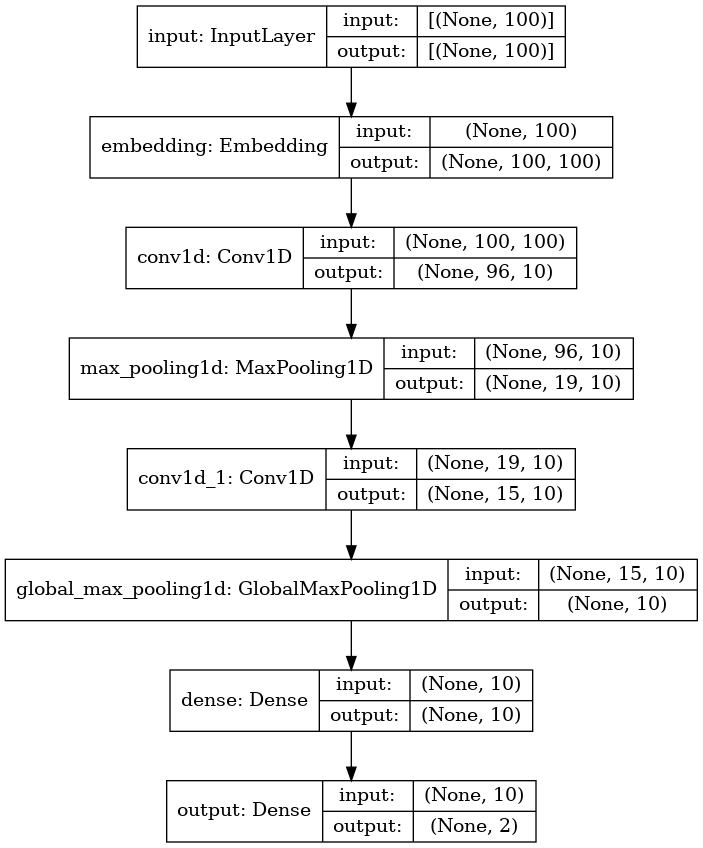

In [5]:
hyperparams_1 = {
    'pX': X_train['normalize_comment'], 
    'py': y_train, 
    'pfasttext': ft, 
    'pno_neurons': 10,
    'pno_filters': 5, 
    'pnum_words': 3000, 
    'pseq_length': 100,
    'pembedding_dim': 100,
    'pbatch_size': 32, 
    'pepochs': 10,
    'psave_path': './models/cnn1d_model_comments_1.h5'
}

model_1 = DeepModel.SentimentCNN1D()
model_1.define(**hyperparams_1)
model_1.model.summary()
plot_model(model_1.model, to_file='./images/cnn1d_model_comments_1.png', show_shapes=True, show_layer_names=True)

In [6]:
model_1.fit(**hyperparams_1)

Epoch 1/10
320/320 [==============================] - 2s 5ms/step - loss: 0.6710 - accuracy: 0.5945 - val_loss: 0.6354 - val_accuracy: 0.6482
Epoch 2/10
320/320 [==============================] - 1s 4ms/step - loss: 0.6153 - accuracy: 0.6507 - val_loss: 0.6123 - val_accuracy: 0.6588
Epoch 3/10
320/320 [==============================] - 1s 5ms/step - loss: 0.5955 - accuracy: 0.6630 - val_loss: 0.6060 - val_accuracy: 0.6588
Epoch 4/10
320/320 [==============================] - 1s 4ms/step - loss: 0.5840 - accuracy: 0.6717 - val_loss: 0.6141 - val_accuracy: 0.6500
Epoch 5/10
320/320 [==============================] - 1s 4ms/step - loss: 0.5757 - accuracy: 0.6723 - val_loss: 0.6043 - val_accuracy: 0.6544
Epoch 6/10
320/320 [==============================] - 1s 4ms/step - loss: 0.5680 - accuracy: 0.6806 - val_loss: 0.6125 - val_accuracy: 0.6667
Epoch 7/10
320/320 [==============================] - 1s 4ms/step - loss: 0.5617 - accuracy: 0.6859 - val_loss: 0.6097 - val_accuracy: 0.6570
Epoch 

> **Nhận xét**:
> * Có thể thấy, model này hoạt động không tốt so với LSTM, trong khi với sô epoch tương ứng LSTM cho ra accuracy và loss value trên validation data tốt hơn nhiều.
> * Như vậy, việc sử dụng các word vectors của fasttext không đem lại hiệu suất tốt cho tập dữ liệu của chúng ta, chúng ta có thể thay đổi kiến trúc của model để có kết quả tốt hơn, nhưng với hiện tai ta có thể phần nào khẳng định rằng các word vector này không đại diện tốt cho tập dữ liệu của chúng ta $\Rightarrow$ Dừng phát triển model này.